In [1]:
# we load the things!


from ngsolve import *

from netgen.geom2d import SplineGeometry
from ngsolve.meshes import MakeStructured3DMesh
from ngsolve.solvers import GMRes
from ngsolve.webgui import Draw
from netgen.csg import * 
#from netgen.meshing import *
# import netgen.gui
# %gui tk

#from netgen.occ import *
#from netgen.meshing import *

import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.optimize import curve_fit
import numpy as np

import pandas as pd

In [2]:
# some helper functions
def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [3]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf, mesh):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf, mesh):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

In [4]:
# Functions for plotting, linear regression fit line for convergence

def reference_line_func(h_values, scaling_factor, slope):

    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):

    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [5]:
# Functions to calculate h_max

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def squared_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1 - v2) ** 2)

def cayley_menger_matrix(vertices):
    if len(vertices) != 4:
        raise ValueError("This method is for a tetrahedron, which requires exactly 4 vertices.")

    # Create the Cayley-Menger matrix (5x5)
    C = np.ones((5, 5))
    for i in range(5):
        C[i, i] = 0 

    for i in range(1, 5):
        for j in range(i+1, 5):
            C[i, j] = C[j, i] = squared_distance(vertices[i-1], vertices[j-1])

    return C

def triangle_area(a, b, c):
    s = (a + b + c) / 2  
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

def circumradius_2D(a, b, c):
    area = triangle_area(a, b, c)
    return a * b * c / (4 * area)

def circumradius_3D(vertices):
    C = cayley_menger_matrix(vertices)

    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Cayley-Menger matrix is singular or not invertible.")

    M = -2 * C_inv
    circumradius = 0.5 * np.sqrt(M[0, 0])

    return circumradius

def calc_hmax(mesh):
    max_h = 0 
    if mesh.dim == 2:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            a = edge_length(vertices[0], vertices[1], 2)
            b = edge_length(vertices[1], vertices[2], 2)
            c = edge_length(vertices[2], vertices[0], 2)
            circumradius = circumradius_2D(a, b, c)
            max_h = max(max_h, circumradius)
    
    elif mesh.dim == 3:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            circumradius = circumradius_3D(vertices)
            max_h = max(max_h, circumradius)
    
    return max_h

def L2errorVOL(u, u_h, mesh, c=1):
    """Function to compute the L2 error in the volume, c=1 by default"""
    errorVOL = Integrate(c*(u - u_h)**2*dx, mesh)
    return errorVOL

def L2errorBND(u, u_h, mesh, c=1):
    """Function to compute the L2 error on the boundary with skeleton=True, c=1 by default"""
    dS = ds(skeleton =True, definedon=mesh.Boundaries(".*"))
    errorBND = Integrate(c*(u - u_h)**2*dS, mesh)
    return errorBND
    

In [6]:
# Create Geometry function

def createGeometry(maxh):
    geo = CSGeometry()
    #geo.Add (OrthoBrick(Pnt(-0.5,-0.5,-0.5), Pnt(0.5,0.5,0.5)))
    geo.Add (Sphere(Pnt(0,0,0), 0.5))
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    #mesh.Curve(2)
    return mesh

def createGeometry2(maxh):
    geo = CSGeometry()
    #geo.Add (OrthoBrick(Pnt(-0.5,-0.5,-0.5), Pnt(0.5,0.5,0.5)))
    geo.Add (OrthoBrick(Pnt(0,0,0), Pnt(1,1,1)))
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    return mesh

def createGeometry1(n):
    structuredMeshUnitBrick = MakeStructured3DMesh(hexes=False, nx=n, ny=n, nz=n)
    return structuredMeshUnitBrick



In [7]:
# Hodge Laplace for 2-forms function
useGMRes = False

def hodgeLaplace2Forms(mesh,
                       g = None, # this is the manufactured solution, when none is given we set it to the zero solution
                       order = 1,
                       C_w = 1):
    
    if g is None:
        g = CF((0,0,0))
    

    H_div = HDiv(mesh, order=order-1, RT=True)     # For 2-forms, H div space
    H_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl) space
    fes = H_curl * H_div
    (p, u), (q, v) = fes.TnT()

    n = specialcf.normal(mesh.dim)
    #n = CF((2*x, 2*y, 2*z)) # analytical normal vector of unit sphere with radius 0.5 and center (0,0,0)
    h = specialcf.mesh_size
    dS = ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    f = CF(GCurl(GCurl(g, mesh), mesh) - GGrad(GDiv(g), mesh))
                
    B, F  = BilinearForm(fes), LinearForm(fes)

    B += curl(p) * v * dx
    B += div(u) * div(v) * dx
    B += curl(q) * u * dx
    B += - p * q * dx

    B +=  - div(u) * v*n * dS
    B +=  - div(v) * u*n * dS
    B +=  (C_w/h) * u*n * v*n * dS

    q_bnd = BoundaryFromVolumeCF(q)

    F += f * v * dx
    F += - div(v) * g*n * dS
    F += (C_w/h) * g*n * v*n * dS
    F += Cross(g, n) * q * dS
    
#with TaskManager(): 
    if (useGMRes == False):
        B.Assemble()
        F.Assemble()
        sol = GridFunction(fes)
        res = F.vec-B.mat * sol.vec
        inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
        sol.vec.data += inv * res
    else:
        #with TaskManager():
        B.Assemble()
        F.Assemble()
        sol = GridFunction(fes)
        blocks = fes.CreateSmoothingBlocks()
        prebj = B.mat.CreateBlockSmoother(blocks)
        GMRes(A =B.mat,x= sol.vec, b=F.vec,pre = prebj,  printrates="\r", maxsteps = 10000, tol=1e-8)
        res = CF((0,0,0))

    plt.plot(F.vec)
    # print(min(np.abs(F.vec)))
    # print(F.vec)

    gf_p , gf_u = sol.components

    # Computation of all quantities needed to derive errors
    div_u = div(gf_u)
    curl_p = curl(gf_p)
    div_g = CF(GDiv(g))
    p_m =  CF(GCurl(g, mesh))
    curl_p_m = CF(GCurl(p_m, mesh))

    div_u_bnd = BoundaryFromVolumeCF(div_u)
    div_g_bnd = BoundaryFromVolumeCF(div_g)

    gf_gamma_u_n = CF(gf_u * n)
    gf_gamma_g_n = CF(g * n)

    gf_gamma_t_u = CF(Cross(n, gf_u))
    gf_gamma_t_g = CF(Cross(n, g))

    h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)
    # Actual error evaluation
    # Computation of L2 errors in the volume
    E_u = L2errorVOL(gf_u, g, mesh)
    E_div_u = L2errorVOL(div_u, div_g, mesh)
    E_H_div_u = E_u + E_div_u
    E_p = L2errorVOL(gf_p, p_m, mesh)
    E_curl_p = L2errorVOL(curl_p, curl_p_m, mesh)
    # Computation of L2 errors on the boundary
    E_gamma_u_n = L2errorBND(gf_gamma_u_n, gf_gamma_g_n, mesh)
    E_gamma_div_u = L2errorBND(div_u_bnd, div_g_bnd, mesh)
    E_u_t_Gamma = L2errorBND(gf_gamma_t_u, gf_gamma_t_g, mesh)
    # Hashtag and X Error norm
    HT_E_gamma_u_n = h_avg**(-1)*E_gamma_u_n
    HT_E_gamma_div_u = h_avg*E_gamma_div_u
    HT_E_u = E_H_div_u + HT_E_gamma_u_n + HT_E_gamma_div_u
    E_h_curl_p = h_avg**2 * E_curl_p
    X_E_u_p = HT_E_u + E_p + E_h_curl_p
    print(sqrt(E_u))
    return (gf_u, gf_p, fes.ndof, Norm(res), 
            sqrt(E_u), sqrt(E_div_u), sqrt(E_H_div_u), 
            sqrt(E_p), sqrt(E_curl_p), 
            sqrt(E_u_t_Gamma), sqrt(E_gamma_u_n), 
            sqrt(HT_E_gamma_u_n), sqrt(HT_E_gamma_div_u), sqrt(HT_E_u), sqrt(E_h_curl_p),
            sqrt(X_E_u_p))

In [8]:
# definition of manufactured solutions

#omega_m_sinusoids_2D = CF((-sin(pi*x)*cos(pi*y), cos(pi*x)*sin(pi*y))) # This one vanishes!
#omega_m_sinusoids_2D = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y))) # This one vanishes!
#g = CF((sin(x)*cos(y)*x*(x-1)*y*(y-1), sin(y)*cos(x)*x*(x-1)*y*(y-1))) # This is a manufactured solution that DOESNT vanish on the boundary!
#g = CF((sin(x)*cos(y)*sin(z)*x*(x-1)*y*(y-1)*z*(z-1), -cos(x)*sin(y)*cos(z)*x*(x-1)*y*(y-1)*z*(z-1),  cos(x)*cos(y)*sin(z)*x*(x-1)*y*(y-1)*z*(z-1)))
#g = CF((sin(x)*cos(y)*sin(z), -cos(x)*sin(y)*cos(z),  cos(x)*cos(y)*sin(z)))
#g = CF((x*(1-x)*sin(pi*x)*sin(pi*z), y*(1-y)*cos(pi*x)*sin(pi*z), z*(1-z)*cos(pi*x)*cos(pi*y)))
#g = CF((x**2,y**2,z**2))
#g = CF((1,1,1))
#g = CF((1,1,1))

# A = 0.05  # Pulse Amplitude
# sigma_pulse = 0.05  # Pulse Width
# r0 = (0.5, 0.5)  # Pulse Center
# n_pulse = (1, 0)  # Pulse Direction

# omega_m_gauss_2D = CF((
#     A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[0],
#     A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[1]
# ))


0.27087356373581956
0.003447958800283291


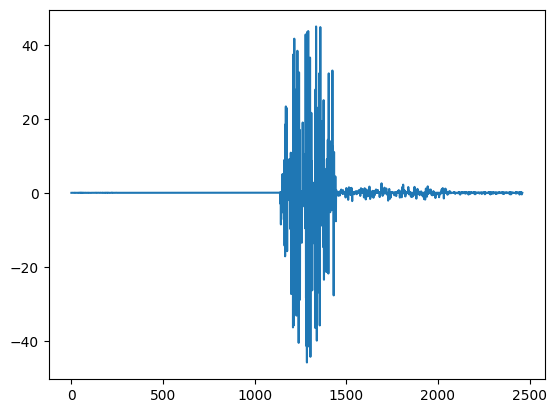

In [9]:
mesh = createGeometry(1)

#mesh.Refine()
#mesh.Refine()
# mesh.Refine()

print(calc_hmax(mesh))

# 0.5: 0.27087356373581956
# 0.15: 0.25037679593829193
# 0.125: 0.18509447288597647
# 0.1: 0.13580729567709426
# 0.06: 0.09516885802041737
# 0.05: 0.07017833139411003
# 0.03: 0.04968454093189725

#g = CF((sin(x)*cos(y)*sin(z), -cos(x)*sin(y)*cos(z),  cos(x)*cos(y)*sin(z)))
#g = CF((R-r, R-r, R-r))

g = CF((sin(x)*cos(y)*cos(z), - sin(z)*cos(y)*sin(x), cos(y)*sin(x)*sin(z)))
order = 2
C_w = 100   

#help(HDiv(mesh, order=1))
results = hodgeLaplace2Forms(mesh, g, order, C_w)
# 0.00011433081099473899
# 0.00011433081099473899
# 0.000114330810994739
#Draw(mesh)

#Draw(mesh)

In [14]:
# n = specialcf.normal(3)
#Draw(results[0], mesh)
# #Draw(Cross(g, n), mesh, "result")
Draw(g, mesh)
# #Draw(n, mesh)
# #mesh.GetBoundaries()
# # gfnv = GridFunction(VectorH1(mesh,order=1))
# # gfnv.Set(specialcf.normal(3), definedon=mesh.Boundaries(".*"))
# #Draw(gfnv, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [11]:
# # Convergence study data generation for 2D

# saveBigCSV = False

# refinementVals = 3
# hmax_init = 2

# maxh_values = [] 

# Cw_vals = logspace_custom_decades(10**0, 1000, 10)
# #Cw_vals = np.linspace(,20,10)

# orders = [1, 2]

# all_results = []

# for i in range(refinementVals):
    
#     #print(f"hmax after refinement {refinement_step}: {h_max_eval}")
#     if (i == 0):
#         mesh = createGeometry(hmax_init)
#     else:
#         mesh.Refine()
        
#     h_max_eval = calc_hmax(mesh)
#     maxh_values.append(h_max_eval)
#     print("doing h_max: ", h_max_eval)

#     for order_cw in orders:
#         results_cw = []
#         print("doing order: ", order_cw)

#         for C_w in Cw_vals:
#             ndof, res, E_u, E_curl_u, E_H_curl_u, \
#             E_p, E_grad_p, \
#             E_gamma_p_u, E_u_n_Gamma, \
#             HT_E_gamma_p_u, HT_E_gamma_n_u, HT_E_u, E_h_grad_p, X_E_u_p = hodgeLaplace2Forms(
#                 mesh, g=g, order=order_cw, C_w=C_w
#             )

#             row_dict = {
#                 'order': order_cw,
#                 'hmax': h_max_eval,
#                 'C_w': C_w,
#                 'ndof': ndof,
#                 'res': res,
#                 'E_u': E_u,
#                 'E_curl_u': E_curl_u,
#                 'E_H_curl_u': E_H_curl_u,
#                 'E_p': E_p,
#                 'E_grad_p': E_grad_p,
#                 'E_gamma_p_u': E_gamma_p_u,
#                 'E_u_n_Gamma': E_u_n_Gamma,
#                 'HT_E_gamma_p_u': HT_E_gamma_p_u,
#                 'HT_E_gamma_n_u': HT_E_gamma_n_u,
#                 'HT_E_u': HT_E_u,
#                 'E_h_grad_p': E_h_grad_p,
#                 'X_E_u_p': X_E_u_p
#             }
#             all_results.append(row_dict)

# df_all_results = pd.DataFrame(all_results)

# if (saveBigCSV == True):
#     df_all_results.to_csv("all_3D_2forms_simulation_results.csv", index=False)

In [12]:
# df_all_results.to_csv("all_3D_1forms_simulation_results.csv", index=False)

In [13]:
# # Convergence study data generation for 2D

# saveBigCSV = True

# refinementVals = 3
# hmax_init = 0.5

# maxh_values = [] 

# Cw_vals = logspace_custom_decades(10**0, 100, 8)
# #Cw_vals = np.linspace(2,12,20)

# orders = [1, 2, 3, 4, 5]

# all_results = []

# for refinement_step in range(refinementVals):
    
#     #print(f"hmax after refinement {refinement_step}: {h_max_eval}")
#     if refinement_step == 0:
#         mesh = createGeometry(hmax_init)
#         mesh.Refine()
#     else:
#         mesh.Refine()

#     h_max_eval = calc_hmax(mesh)
#     maxh_values.append(h_max_eval)
#     print("doing h_max: ", h_max_eval)

#     for order_cw in orders:
#         results_cw = []
#         print("doing order: ", order_cw)

#         for C_w in Cw_vals:
#             g = omega_m_sinusoids_2D

#             ndof, res, L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_Gamma, HT_error_u, HT_error_gamma_n, HT_error_gamma_p = hodgeLaplace1Forms(
#                 mesh, g=g, order=order_cw, C_w=C_w
#             )

#             row_dict = {
#                 'order': order_cw,
#                 'hmax': h_max_eval,
#                 'C_w': C_w,
#                 'ndof': ndof,
#                 'res': res,
#                 'L2_error_u': L2_error_u,
#                 'L2_error_curl_u': L2_error_curl_u,
#                 'L2_error_p': L2_error_p,
#                 'L2_error_grad_p': L2_error_grad_p,
#                 'L2_error_gamma_p_u': L2_error_gamma_p_u,
#                 'L2_error_u_n': L2_error_u_n,
#                 'L2_error_p_Gamma': L2_error_p_Gamma,
#                 'HT_error_u': HT_error_u,
#                 'HT_error_gamma_n': HT_error_gamma_n,
#                 'HT_error_gamma_p': HT_error_gamma_p
#             }
#             all_results.append(row_dict)

# df_all_results = pd.DataFrame(all_results)

# if (saveBigCSV == True):
#     df_all_results.to_csv("all_2D_1forms_simulation_results.csv", index=False)
    